In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
from obspy import Trace, Stream, read
import scipy
from scipy.integrate import cumtrapz
from scipy.fftpack import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftfreq
from scipy import signal
from scipy import ndimage
import math
from math import ceil
from multitaper import MTSpec

import transferfns as tf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Define directories and file names
datadir = "data/"
event_ps1_way = {"geo": ("20190427202045.868.segy", 24270), "das": ("DAS_FORGE_201904272020575.segy",9150)}

1025 976
(976, 1025)
(976, 1025)


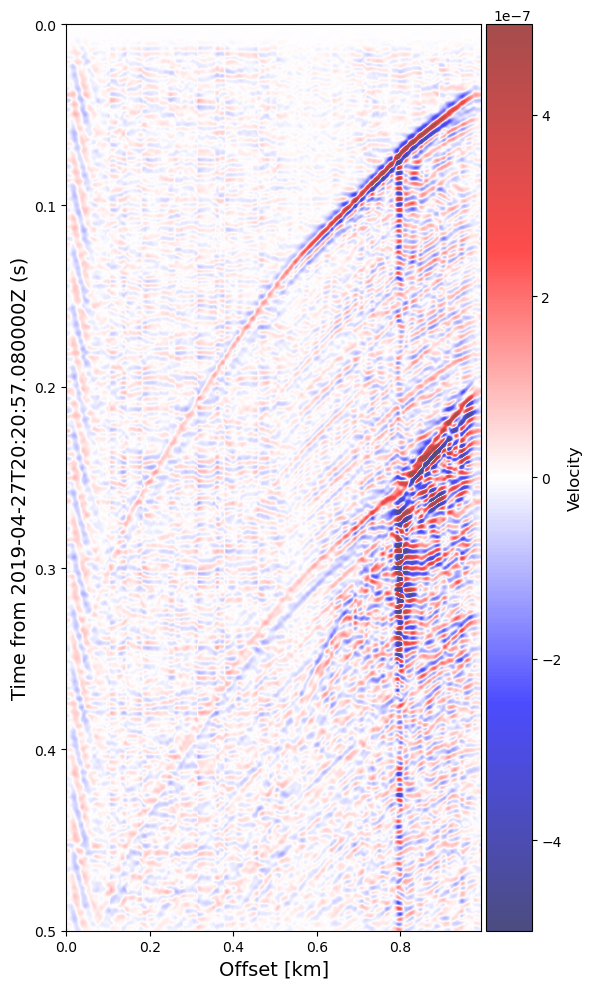

In [73]:
fpath_ps1_DAS = datadir + "/" + event_ps1_way["das"][0]

st_das=tf.segy2stream(fpath_ps1_DAS,network='FORGE',channel_spacing=1.02)

das_start=st_das[0].stats.starttime
st_das=st_das.slice(das_start+0.08,das_start+0.5120+0.08)
das_start=st_das[0].stats.starttime

st_das.taper(max_percentage=0.01,type='cosine')
st_das=st_das.filter(type='bandpass',freqmin=5,freqmax=250)

st_das=tf.median_remove(st_das)

st_strain=tf.to_strain(st_das)
    
st_strain=st_strain.filter(type='bandpass',freqmin=5,freqmax=250)

st_tmp=st_strain.copy()
st_vel=tf.fk_filter(st_tmp, wavenumber_limits=(-2, 2), freq_limits=(-400, 400), taper=0.1,resample=True,eta=1e-2,plot=False)

fig=plt.figure(figsize=[6,10])
fig=tf.image(st_vel,style=1,skip=1,tmax=0.5,clim=[-5e-7,5e-7], physicalFiberLocations=True,fig=fig)
plt.ylabel('Time from %s (s)'%(das_start),fontsize=14)
plt.show()

## Transfer DAS data to Velocity and apply correction

DAS at channel at 767.04


/Users/ab14785/opt/anaconda3/envs/mtspec/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)


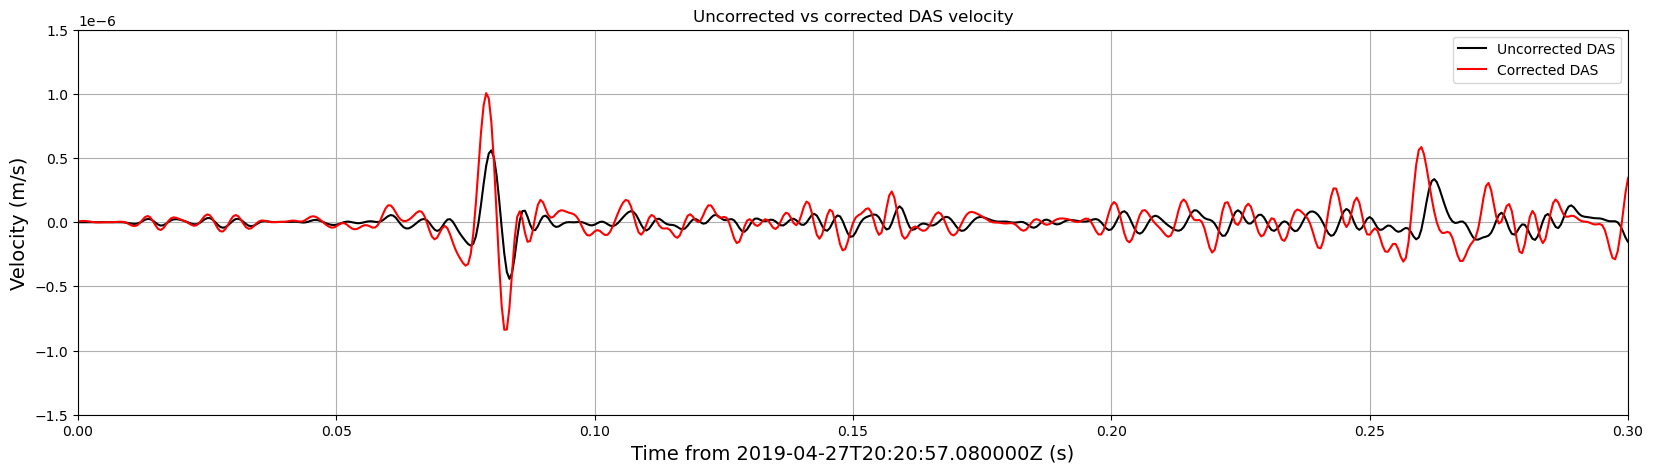

In [74]:
i=752
print('DAS at channel at %s'%(st_vel[i].stats.distance))


das_start=st_vel[i].stats.starttime

nstack=4
nstack=int(nstack/2)
st_stack=st_vel[i-nstack:i+nstack].copy()

st_stack=st_stack.stack()


DAS_freq = fftshift(fft(st_stack[0].data))

H_DAS = np.load("data/H_mean_tot_new.npy")

freqmin=-250
freqmax=250
n=11

H_DAS_av=tf.moving_average(H_DAS,n)

H_DAS_av_wl=[]
wl=0.3

for val in H_DAS_av:
    if np.abs(val) < wl:
        H_DAS_av_wl.append(wl)
    else:
        H_DAS_av_wl.append(val)


# H_DAS = np.load("data/H_mean_tot_new.npy")
DAS_vel_correct_f = (DAS_freq[int((n-1)/2):-int((n-1)/2)] * np.conjugate(H_DAS_av_wl)) / (np.abs(H_DAS_av_wl)*np.abs(H_DAS_av_wl))
DAS_vel_correct = np.real(ifft(ifftshift(DAS_vel_correct_f),axis=0))

DAS_vel_correct_dim = DAS_vel_correct.reshape(-1,1)

nt = DAS_vel_correct.shape[0]

list_traces = []    
for i in range(0,DAS_vel_correct_dim.shape[1]):         
    list_traces.append(Trace(data=DAS_vel_correct_dim[:,i], header={"delta":0.0005, "npts": nt}))    
stream_out = Stream(traces = list_traces)

for j in range(0,len(stream_out)):
    stream_out[j].filter("bandpass", freqmin = 50, freqmax = 500, corners=4, zerophase=True)

# Plot DAS and Geophone data together
plt.figure(figsize=[20,5])
plt.title("Uncorrected vs corrected DAS velocity")
# plt.plot(st_geo.times(),st_geo.data,c='g',label='Geophone')
plt.plot(st_stack[0].times(),st_stack[0].data,'k',label='Uncorrected DAS')

plt.plot(stream_out[0].times(),stream_out[0].data,'r',label='Corrected DAS')

plt.xlabel('Time from %s (s)'%(das_start),fontsize=14)
plt.ylabel('Velocity (m/s)',fontsize=14)
plt.ylim(-1.5e-6,1.5e-6)
plt.xlim(0,0.3)
plt.legend()
plt.grid()
plt.show()

## Uncorrected 

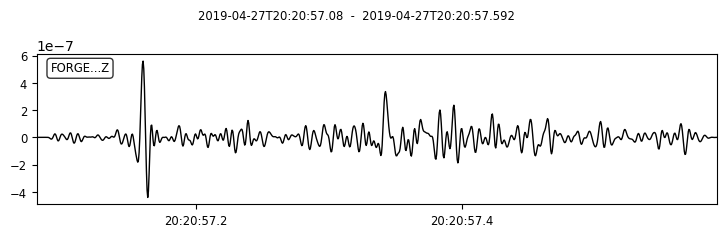

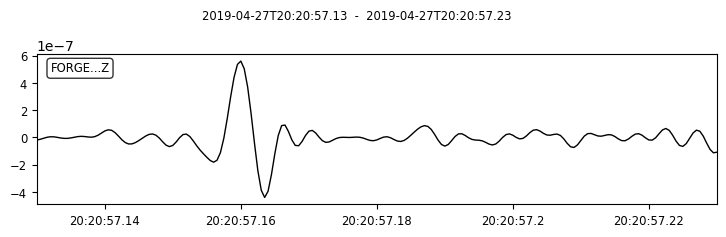

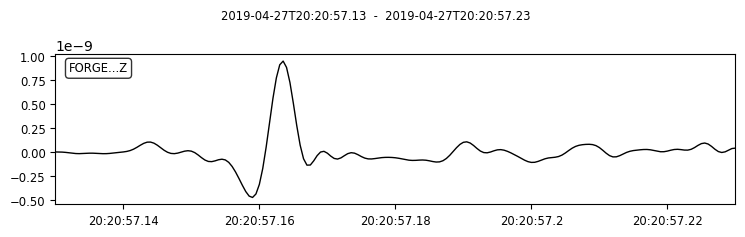

In [69]:
uncorr_st_vel=st_stack.copy()
uncorr_st_vel.plot()
start=uncorr_st_vel[0].stats.starttime
uncorr_st_vel=uncorr_st_vel.slice(start+0.05,start+0.15)
uncorr_st_vel.plot()

uncorr_st=tf.to_displacement(uncorr_st_vel)
uncorr_st.plot()
plt.show()

## H Corrected Data

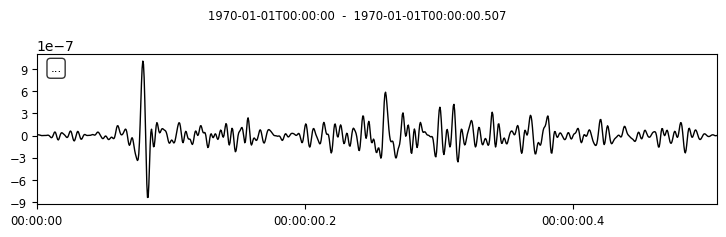

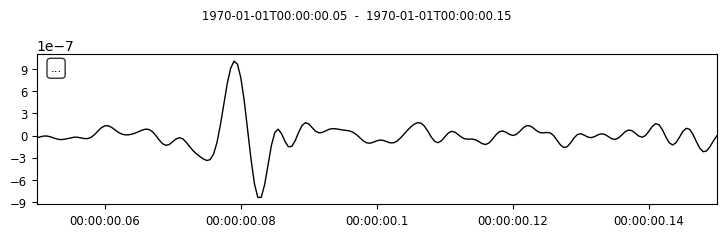

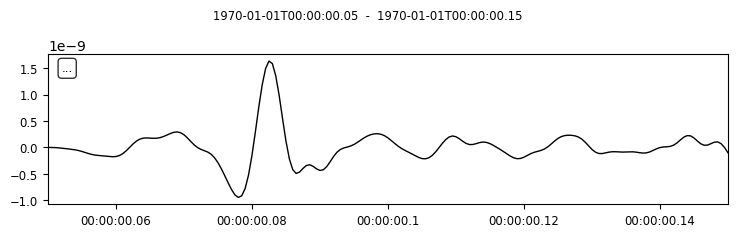

In [77]:
st_vel=stream_out.copy()
st_vel.plot()
start=st_vel[0].stats.starttime
st_vel=st_vel.slice(start+0.05,start+0.15)
st_vel.plot()

corr_st=tf.to_displacement(st_vel)
corr_st.plot()
plt.show()

## Uncorrected Displacement

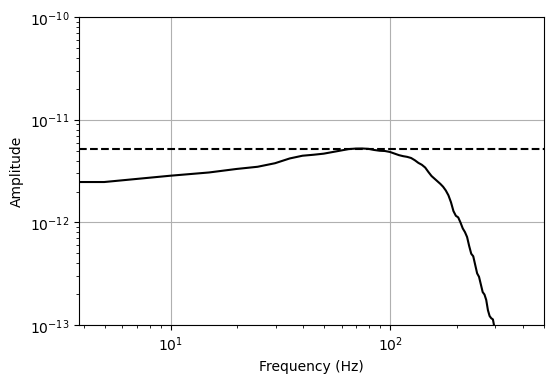

Seismic Moment = 15639305.059423087
Moment Magnitude = -1.203855032630969


In [59]:
amp_max=tf.mtspec(uncorr_st[0])

rho=2500
vp=5700
vs=3100
r=1400
R=0.44
F=1

omega_0=amp_max

M_0=((4.*np.pi*rho*(vs**3)*r*(omega_0))/(R*F))
print('Seismic Moment = %s'%M_0)


M_W=((2./3.0)*np.log10(M_0))-6.0
print('Moment Magnitude = %s'%M_W)

## H Corrected Displacement

/Users/ab14785/Library/CloudStorage/OneDrive-UniversityofBristol/01-Coding/6-Github_repos/FORGE/FORGE_Transfer-fn/transferfns.py:375: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.show()


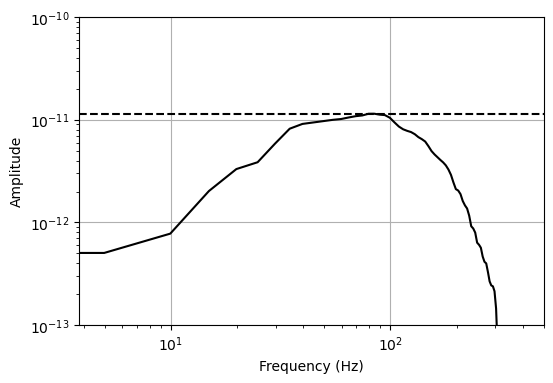

Seismic Moment = 36309672.03964811
Moment Magnitude = -0.9599851158356234


In [78]:
amp_max=tf.mtspec(corr_st[0])

rho=2500
vp=5700
vs=3100
r=1400
R=0.44
F=1

deg=20
rad=deg*np.pi/180
omega_0=amp_max/np.cos(rad)
# omega_0=amp_max

M_0=((4.*np.pi*rho*(vs**3)*r*(omega_0))/(R*F))
print('Seismic Moment = %s'%M_0)


M_W=((2./3.0)*np.log10(M_0))-6.0
print('Moment Magnitude = %s'%M_W)